# Final LDA Model

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

from datetime import datetime

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # Author: don't skip this
# pyLDAvis.gensim.prepare

# I think i need another one:
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')
stop_words.extend(['tenlastelegging\\n\\n\\naan', '\\n\\n\\n\\n\\n\\n', '\\n\\n\\n\\n\\n', '\\n\\n', 'een', 'naan', 'nde', 'nhij', '\\n'])

# Data Final

In [109]:
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/dataset_10012022_cleaned.csv', index_col=6, parse_dates=['date']) 
df.head()

df_be = df[df['bewijs'] != '[]'] #bewijs
df_te = df[df['tll'] != '[]'] #tenlastelegging

df['bete'] = df['bewijs'] + df['tll'] 
df = df[df['bete'] != '[][]']
df = df.drop(labels=['bewijs', 'tll'], axis=1)


In [110]:
df18 = df.loc["2018-01-01 00:00:00":"2018-12-31 00:00:00"]
df19 = df.loc["2019-01-01 00:00:00":"2019-12-31 00:00:00"]
df20 = df.loc["2020-01-01 00:00:00":"2020-12-31 00:00:00"]
df21 = df.loc["2021-01-01 00:00:00":"2021-12-31 00:00:00"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated 

In [124]:
print(df18.shape)
print(df19.shape)
print(df20.shape)
print(df21.shape)

(300, 7)
(306, 7)
(315, 7)
(527, 7)


# Build Giant Function

In [157]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
        

def get_lda_model(df):
    data_words = list(sent_to_words(df['bete']))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    # nlp = spacy.load('nl', disable=['parser', 'ner'])

    nlp = spacy.load("nl_core_news_sm")

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # corpus1 = [str(item) for item in corpus]

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=5, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

    return(lda_model, data_lemmatized, corpus, id2word)

In [158]:
d = [df18, df19, df20, df21]
q = 1
lda_models = []
dat_lems = []
corps = []
ids = []

for i in d:
    print(q)
    q += 1
    l, dl, c, i = get_lda_model(i)
    lda_models.append(l)
    dat_lems.append(dl)
    corps.append(c)
    ids.append(i)



1
2
3
4


In [156]:
d[3]

,Unnamed: 0,filename,ecli,subject,spatial,case_nr,bete
date,,,,,,,
2021-02-10,7,ECLI_NL_RBOVE_2021_606.xml,ECLI:NL:RBOVE:2021:606,Strafrecht,Almelo,08/760218-17 (P),"[][' tenlastelegging de verdenking komt er, ..."
2021-02-10,8,ECLI_NL_GHSHE_2021_1801.xml,ECLI:NL:GHSHE:2021:1801,Strafrecht,'s-Hertogenbosch,20-003457-18,[' bewijsmiddelen indien tegen dit ve...
2021-02-09,16,ECLI_NL_RBROT_2021_2966.xml,ECLI:NL:RBROT:2021:2966,Strafrecht,Rotterdam,10.295806.20,[' bewijswaardering 4.1.1. standpunt verd...
2021-02-02,28,ECLI_NL_RBAMS_2021_378.xml,ECLI:NL:RBAMS:2021:378,Strafrecht,Amsterdam,13/701115-19,[][' 2tenlastelegging aan verdachte is – ko...
2021-02-23,43,ECLI_NL_GHDHA_2021_497.xml,ECLI:NL:GHDHA:2021:497,Strafrecht,Den Haag,2200469519,[' bewijsvoering het hof grondt zijn ...
...,...,...,...,...,...,...,...
2021-02-03,2882,ECLI_NL_RBROT_2021_1286.xml,ECLI:NL:RBROT:2021:1286,Strafrecht,Rotterdam,10/750172-20,[][' tenlastelegging aan de verdachte word...
2021-02-25,2898,ECLI_NL_RBZWB_2021_786.xml,ECLI:NL:RBZWB:2021:786,Strafrecht,Middelburg,02-220946-20,[][' tenlastelegging de tenlastelegging is ge...
2021-02-25,2902,ECLI_NL_RBNHO_2021_1491.xml,ECLI:NL:RBNHO:2021:1491,Strafrecht,Haarlem,15/246961-19,[][' 1tenlastelegging aan verdachte is ten l...


# Building the Topic Model

In [136]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corp18,
                                           id2word=i2w18,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in LDA model

In [137]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.075*"slachtoffer" + 0.039*"verdenken" + 0.017*"althans" + 0.014*"naam" + '
  '0.013*"slaan" + 0.011*"rechtbank" + 0.010*"ander" + 0.008*"zien" + '
  '0.008*"medeverdacht" + 0.008*"verklaren"'),
 (1,
  '0.040*"verdenken" + 0.027*"ander" + 0.016*"althans" + 0.016*"geval" + '
  '0.013*"slachtoffer" + 0.011*"feit" + 0.011*"naam" + 0.010*"geld" + '
  '0.010*"goed" + 0.010*"mededader"'),
 (2,
  '0.049*"verdenken" + 0.036*"slachtoffer" + 0.021*"naam" + '
  '0.013*"aangeefster" + 0.011*"zeggen" + 0.011*"rechtbank" + 0.010*"gaan" + '
  '0.009*"feit" + 0.008*"weten" + 0.008*"maken"'),
 (3,
  '0.029*"verdenken" + 0.023*"betrokken" + 0.021*"adres" + '
  '0.018*"medeverdacht" + 0.017*"man" + 0.015*"woning" + 0.014*"verbalisant" + '
  '0.012*"plaats" + 0.012*"zien" + 0.009*"komen"'),
 (4,
  '0.037*"verdenken" + 0.011*"althans" + 0.010*"ander" + 0.009*"rechtbank" + '
  '0.009*"feit" + 0.008*"naam" + 0.008*"hof" + 0.007*"verklaren" + '
  '0.007*"bedrag" + 0.007*"weten"')]


# Compute Model Perplexity and Coherence Score

In [112]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.197103925749577

Coherence Score:  0.4805791301370833


# Visualize the topics-keywords

In [162]:
# 18 = 0 / 19 = 1 / 20 = 2 / 21 = 3

a = 3

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_models[a], corps[a], ids[a], R = 10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.043129 -0.060756       1        1  45.349316
3     -0.197275 -0.009482       2        1  19.700065
0      0.099694 -0.144908       3        1  14.537534
1      0.107685  0.038179       4        1  10.576052
2      0.033024  0.176967       5        1   9.837033, topic_info=             Term         Freq        Total Category  logprob  loglift
581   slachtoffer  6909.000000  6909.000000  Default  10.0000  10.0000
28           naam  5042.000000  5042.000000  Default   9.0000   9.0000
4         althans  2442.000000  2442.000000  Default   8.0000   8.0000
1779     kenteken  1171.000000  1171.000000  Default   7.0000   7.0000
691       bedrijf  1180.000000  1180.000000  Default   6.0000   6.0000
...           ...          ...          ...      ...      ...      ...
32        periode   272.750680   997.510318   Topic5  -4.8118   1.0223
581   slachtoffer   435.866482  6909.459193   Topic5  -4.3431  -0.4443
203         weten   280.231505  1933.350502   Topic5  -4.7848   0.3876
4         althans   269.737299  2442.685664   Topic5  -4.8229   0.1156
6           ander   246.469160  2617.053963   Topic5  -4.9132  -0.0436

[140 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
456       1  0.911637       aangeefster
456       2  0.087399       aangeefster
211       1  0.167600        aantreffen
211       2  0.042922        aantreffen
211       3  0.622367        aantreffen
...     ...       ...               ...
443       2  0.026017              zien
443       3  0.071954              zien
443       4  0.002846              zien
443       5  0.004472              zien
5860      1  0.991508  zover_inhoudenen

[296 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 2, 3])

# How to find the optimal number fo topics for LDA?

In [114]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [115]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=15, step=1)  # 2,40,6

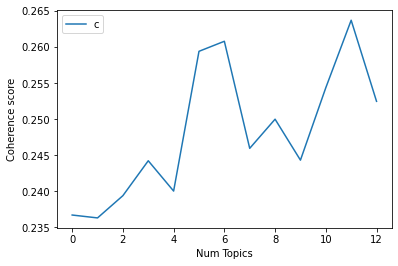

In [116]:
# Show graph

plt.plot(coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# TF-IDF

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_distances

In [118]:
sample = list(df['bete'])

# Approach 2

In [119]:
dat_lem_untok = [" ".join(x) for x in data_lemmatized]
tfidf_vectorizer = TfidfVectorizer(input=dat_lem_untok, stop_words=stop_words)

In [120]:
tfidf_vector = tfidf_vectorizer.fit_transform(dat_lem_untok)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['tenlastelegging'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [121]:
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names())

In [122]:
tfidf_df.stack().reset_index()

,level_0,level_1,0
0,0,aa,0.0
1,0,aa_flesje,0.0
2,0,aaan,0.0
3,0,aaei,0.0
4,0,aafe,0.0
...,...,...,...
30914795,1447,zwoll,0.0
30914796,1447,zwolle,0.0
30914797,1447,zwz,0.0
30914798,1447,zygoma,0.0


In [123]:
tfidf_df = tfidf_df.stack().reset_index()
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})
tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)
top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

In [124]:
top_tfidf[top_tfidf['term'].str.contains('hof')]

,document,term,tfidf
29008,1,hof,0.175662
71708,3,hof,0.527818
93058,4,hof,0.197094
114408,5,hof,0.155718
199808,9,hof,0.272591
...,...,...,...
29897658,1400,hof,0.231139
30196558,1414,hof,0.315010
30217908,1415,hof,0.186256
30708958,1438,hof,0.275683


In [125]:
# Doesn't work due to the length constraint of a document (max. 5000)

import altair as alt
import numpy as np

# Terms in this list will get a red dot in the visualization
term_list = ['benadelen', 'kasboek', 'hof']

# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand = top_tfidf_plusRand.iloc[:500,]
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf_plusRand.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# red circle over terms in above list
circle = base.mark_circle(size=100).encode(
    color = alt.condition(
        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
        alt.value('red'),
        alt.value('#FFFFFF00')        
    )
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + circle + text).properties(width = 1200)

alt.LayerChart(...)